In [2]:
import torch
from torch.nn import functional as F
from torch import nn
from pytorch_lightning.core.lightning import LightningModule
import pytorch_lightning as pl

import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import pickle

if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

import json
import argparse
import sys

import matplotlib.pyplot as plt
import pandas as pd
from IPython.core.display import HTML
import sys

In [3]:
sys.path = sys.path[:8]
sys.path

['/home/jupyter/nwp-downscale/notebooks',
 '/opt/conda/envs/ilan/lib/python39.zip',
 '/opt/conda/envs/ilan/lib/python3.9',
 '/opt/conda/envs/ilan/lib/python3.9/lib-dynload',
 '',
 '/opt/conda/envs/ilan/lib/python3.9/site-packages',
 '/opt/conda/envs/ilan/lib/python3.9/site-packages/IPython/extensions',
 '/home/jupyter/.ipython']

# Load config and results

In [4]:
config_path = '../experiments/eval_leingan_ens10_tp_stacked_input.json'
args = json.load(open(config_path))
parser = argparse.ArgumentParser(args)
parser.set_defaults(**args)
args, _ = parser.parse_known_args()
folder = args.save_hparams["save_dir"] + args.save_hparams["run_name"] + str(args.save_hparams["run_number"])+"/"
# leingan_ens10_tp_stacked_full_field_metrics = pickle.load(open(folder+"full_field_eval_metrics.pkl", "rb"))
leingan_ens10_tp_stacked_patch_metrics = pickle.load(open(folder+"patch_eval_metrics.pkl", "rb"))
leingan_ens10_tp_stacked_preds = plt.imread(folder+'sample_predictions.png', format='png')

config_path = '../experiments/eval_leingan_single_forecast_tp_input.json'
args = json.load(open(config_path))
parser = argparse.ArgumentParser(args)
parser.set_defaults(**args)
args, _ = parser.parse_known_args()
folder = args.save_hparams["save_dir"] + args.save_hparams["run_name"] + str(args.save_hparams["run_number"])+"/"
# leingan_single_forecast_full_field_metrics = pickle.load(open(folder+"full_field_eval_metrics.pkl", "rb"))
leingan_single_forecast_preds = plt.imread(folder+'sample_predictions.png', format='png')
leingan_single_forecast_patch_metrics = pickle.load(open(folder+"patch_eval_metrics.pkl", "rb"))

config_path = '../experiments/eval_wgan-gp_single_forecast_tp.json'
args = json.load(open(config_path))
parser = argparse.ArgumentParser(args)
parser.set_defaults(**args)
args, _ = parser.parse_known_args()
folder = args.save_hparams["save_dir"] + args.save_hparams["run_name"] + str(args.save_hparams["run_number"])+"/"
# wgan_gp_full_field_metrics = pickle.load(open(folder+"full_field_eval_metrics.pkl", "rb"))
wgan_gp_patch_metrics = pickle.load(open(folder+"patch_eval_metrics.pkl", "rb"))
wgan_gp_preds = plt.imread(folder+'sample_predictions.png', format='png')


config_path = '../experiments/eval_wgan-gp-smoothed_single_forecast_tp.json'
args = json.load(open(config_path))
parser = argparse.ArgumentParser(args)
parser.set_defaults(**args)
args, _ = parser.parse_known_args()
folder = args.save_hparams["save_dir"] + args.save_hparams["run_name"] + str(args.save_hparams["run_number"])+"/"
# wgan_gp_smoothed_full_field_metrics = pickle.load(open(folder+"full_field_eval_metrics.pkl", "rb"))
wgan_gp_smoothed_patch_metrics = pickle.load(open(folder+"patch_eval_metrics.pkl", "rb"))
wgan_gp_smoothed_preds = plt.imread(folder+'sample_predictions.png', format='png')

config_path = '../experiments/eval_leingan_ens10_tp_random_input.json'
args = json.load(open(config_path))
parser = argparse.ArgumentParser(args)
parser.set_defaults(**args)
args, _ = parser.parse_known_args()
folder = args.save_hparams["save_dir"] + args.save_hparams["run_name"] + str(args.save_hparams["run_number"])+"/"
# leingan_ens10_tp_random_full_field_metrics = pickle.load(open(folder+"full_field_eval_metrics.pkl", "rb"))
leingan_ens10_tp_random_patch_metrics = pickle.load(open(folder+"patch_eval_metrics.pkl", "rb"))
leingan_ens10_tp_random_preds = plt.imread(folder+'sample_predictions.png', format='png')

config_path = '../experiments/eval_leingan_single_forecast_tp_with_consts_input.json'
args = json.load(open(config_path))
parser = argparse.ArgumentParser(args)
parser.set_defaults(**args)
args, _ = parser.parse_known_args()
folder = args.save_hparams["save_dir"] + args.save_hparams["run_name"] + str(args.save_hparams["run_number"])+"/"
# leingan_single_forecast_with_consts_full_field_metrics = pickle.load(open(folder+"full_field_eval_metrics.pkl", "rb"))
leingan_single_forecast_with_consts_patch_metrics = pickle.load(open(folder+"patch_eval_metrics.pkl", "rb"))
leingan_single_forecast_with_consts_preds = plt.imread(folder+'sample_predictions.png', format='png')

config_path = '../experiments/eval_leingan_ens10_tp_random_added_vars_TCW-T-CAPE-CIN.json'
args = json.load(open(config_path))
parser = argparse.ArgumentParser(args)
parser.set_defaults(**args)
args, _ = parser.parse_known_args()
folder = args.save_hparams["save_dir"] + args.save_hparams["run_name"] + str(args.save_hparams["run_number"])+"/"
# leingan_ens10_added_vars_full_field_metrics = pickle.load(open(folder+"full_field_eval_metrics.pkl", "rb"))
leingan_ens10_added_vars_preds = plt.imread(folder+'sample_predictions.png', format='png')
leingan_ens10_added_vars_patch_metrics = pickle.load(open(folder+"patch_eval_metrics.pkl", "rb"))



In [9]:
scalar_metrics = pd.DataFrame(columns=["model", "crps", "avg_pool_crps", "max_pool_crps", "rmse"])

models = [
#           ('leingan_single_forecast_full_field', leingan_single_forecast_full_field_metrics), 
#           ('leingan_ens10_tp_stacked_full_field', leingan_ens10_tp_stacked_full_field_metrics), 
#           ('wgan_gp_full_field', wgan_gp_full_field_metrics),
#           ('wgan_gp_smoothed_full_field', wgan_gp_smoothed_full_field_metrics), 
#           ('leingan_single_forecast_with_consts_full_field', leingan_single_forecast_with_consts_full_field_metrics), 
#           ('leingan_ens10_tp_random_full_field', leingan_ens10_tp_random_full_field_metrics), 
#           ('leingan_ens10_added_vars_full_field', leingan_ens10_added_vars_full_field_metrics),
          ('leingan_single_forecast_patch', leingan_single_forecast_patch_metrics), 
          ('leingan_ens10_tp_stacked_patch', leingan_ens10_tp_stacked_patch_metrics), 
          ('wgan_gp_patch', wgan_gp_patch_metrics),
          ('wgan_gp_smoothed_patch', wgan_gp_smoothed_patch_metrics), 
          ('leingan_single_forecast_with_consts_patch', leingan_single_forecast_with_consts_patch_metrics), 
          ('leingan_ens10_tp_random_patch', leingan_ens10_tp_random_patch_metrics), 
          ('leingan_ens10_added_vars_patch', leingan_ens10_added_vars_patch_metrics)
        ]

for (model_name, metrics) in models: 
    scalar_metrics = scalar_metrics.append({"model": model_name, "crps":metrics["crps"], 
                  "avg_pool_crps":metrics["avg_pool_crps"], 
                  "max_pool_crps":metrics["max_pool_crps"], 
                  "rmse":metrics["rmse"]}, ignore_index=True)
scalar_metrics

model      crps  avg_pool_crps  \
0              leingan_single_forecast_patch  0.351096       0.343050   
1             leingan_ens10_tp_stacked_patch  0.386971       0.384850   
2                              wgan_gp_patch  0.356716       0.346941   
3                     wgan_gp_smoothed_patch  0.332773       0.323709   
4  leingan_single_forecast_with_consts_patch  0.357854       0.350497   
5              leingan_ens10_tp_random_patch  0.347917       0.340552   
6             leingan_ens10_added_vars_patch  0.593659       0.624219   

   max_pool_crps      rmse  
0       0.586708  1.056507  
1       0.695095  1.344685  
2       0.587950  1.013487  
3       0.565542  1.026931  
4       0.597780  1.120847  
5       0.588700  1.016366  
6       1.210755  2.074530

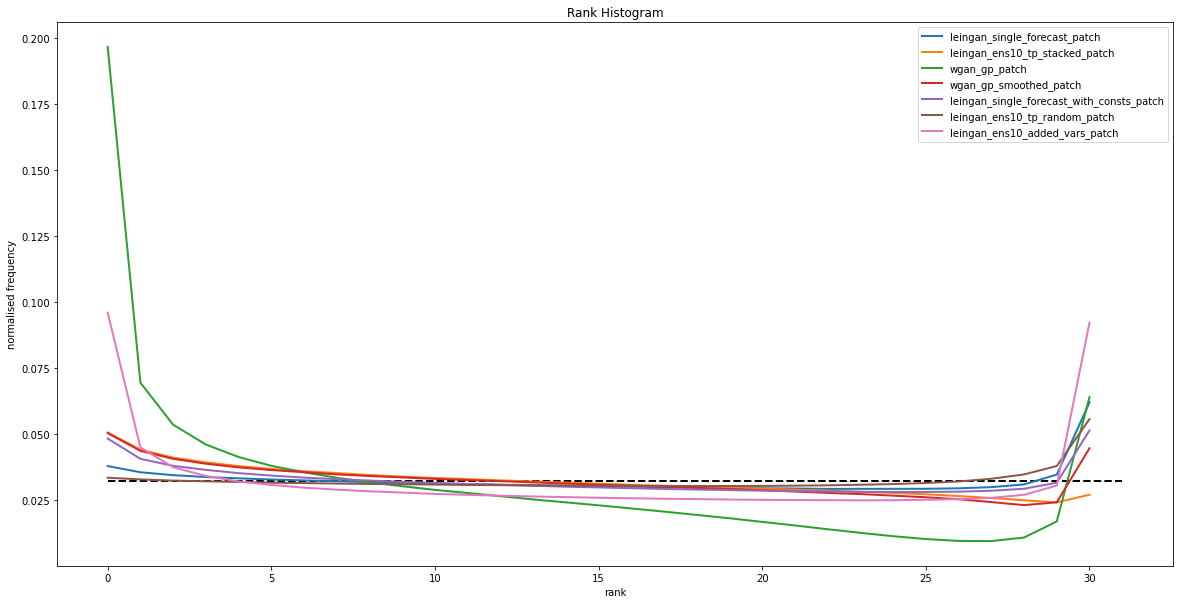

In [10]:
plt.figure(figsize=(20,10))
for (model_name, metrics) in models: 
    plt.plot(metrics['rankhist']/np.sum(metrics['rankhist']), label=model_name, linewidth=2)
plt.hlines(y = 1/31, xmin=0, xmax=31, color='k', linestyle='--', linewidth=2)
plt.xlabel('rank')
plt.ylabel('normalised frequency')
plt.title('Rank Histogram')
plt.legend()

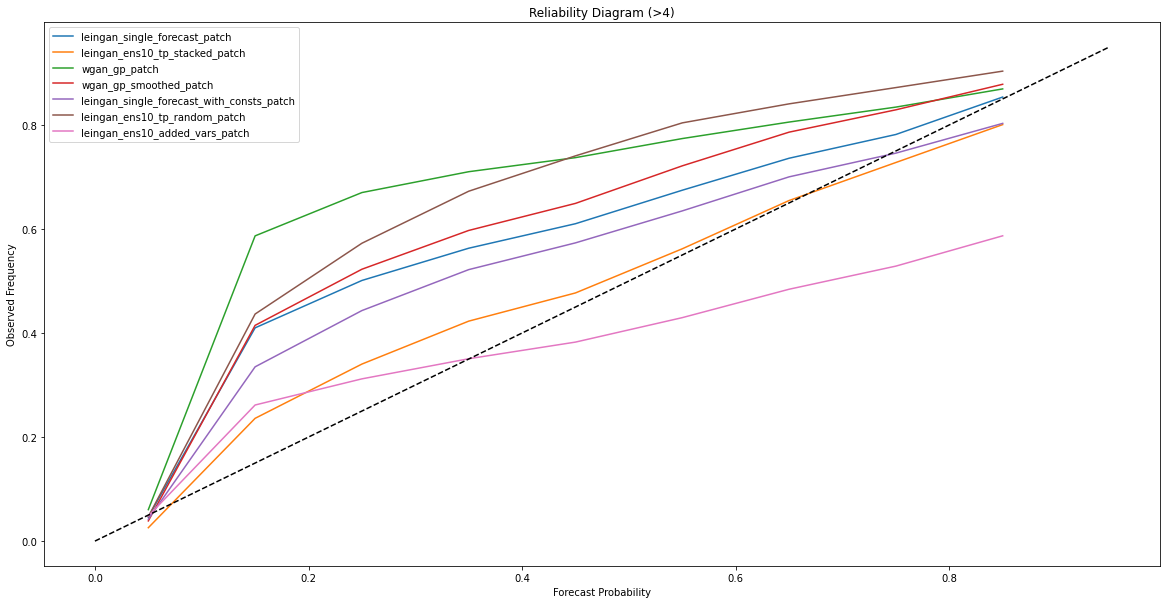

In [11]:
plt.figure(figsize=(20,10))

for (model_name, metrics) in models: 
    relative_freq, forecast_probs, samples = metrics['reliability_4']
    plt.plot(forecast_probs, relative_freq, label=model_name)
plt.plot(np.linspace(0, 0.95, len(forecast_probs)), np.linspace(0, 0.95, len(forecast_probs)), 'k--')
plt.xlabel('Forecast Probability')
plt.ylabel('Observed Frequency')
plt.title('Reliability Diagram (>4)')
plt.legend()

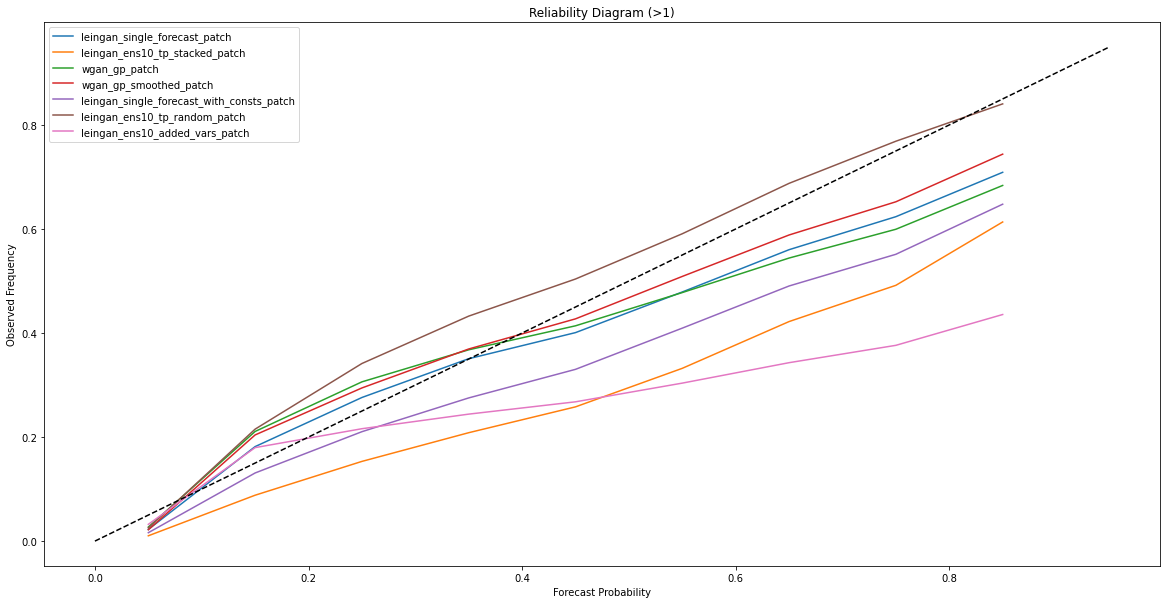

In [8]:
plt.figure(figsize=(20,10))

for (model_name, metrics) in models: 
    relative_freq, forecast_probs, samples = metrics['reliability_1']
    plt.plot(forecast_probs, relative_freq, label=model_name)
plt.plot(np.linspace(0, 0.95, len(forecast_probs)), np.linspace(0, 0.95, len(forecast_probs)), 'k--')
plt.xlabel('Forecast Probability')
plt.ylabel('Observed Frequency')
plt.title('Reliability Diagram (>1)')
plt.legend()

# Visualising predictions samples

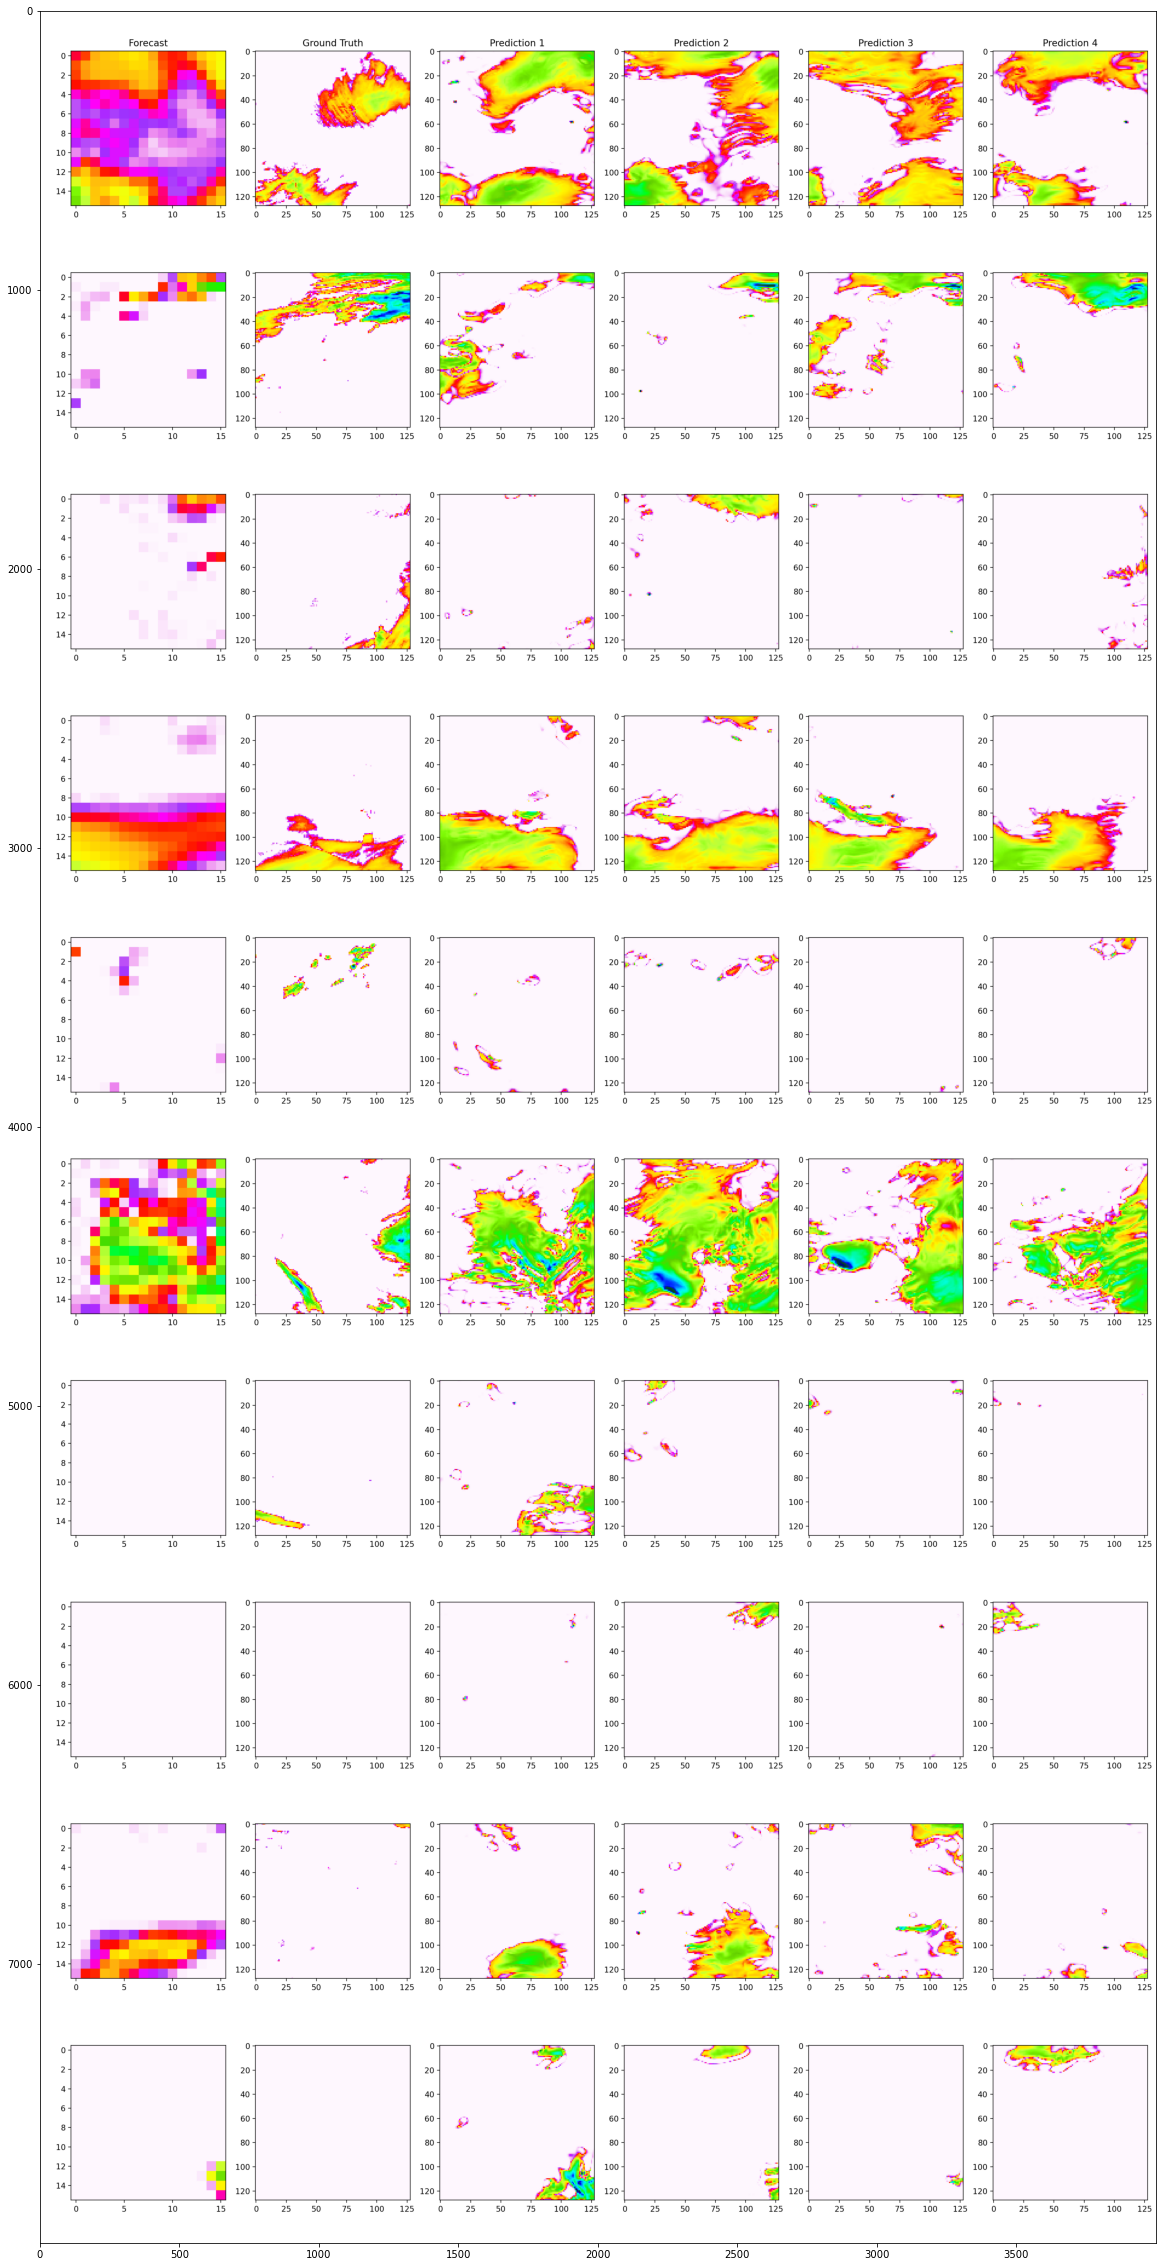

In [13]:
plt.figure(figsize=(20, 45))
plt.imshow(lein)

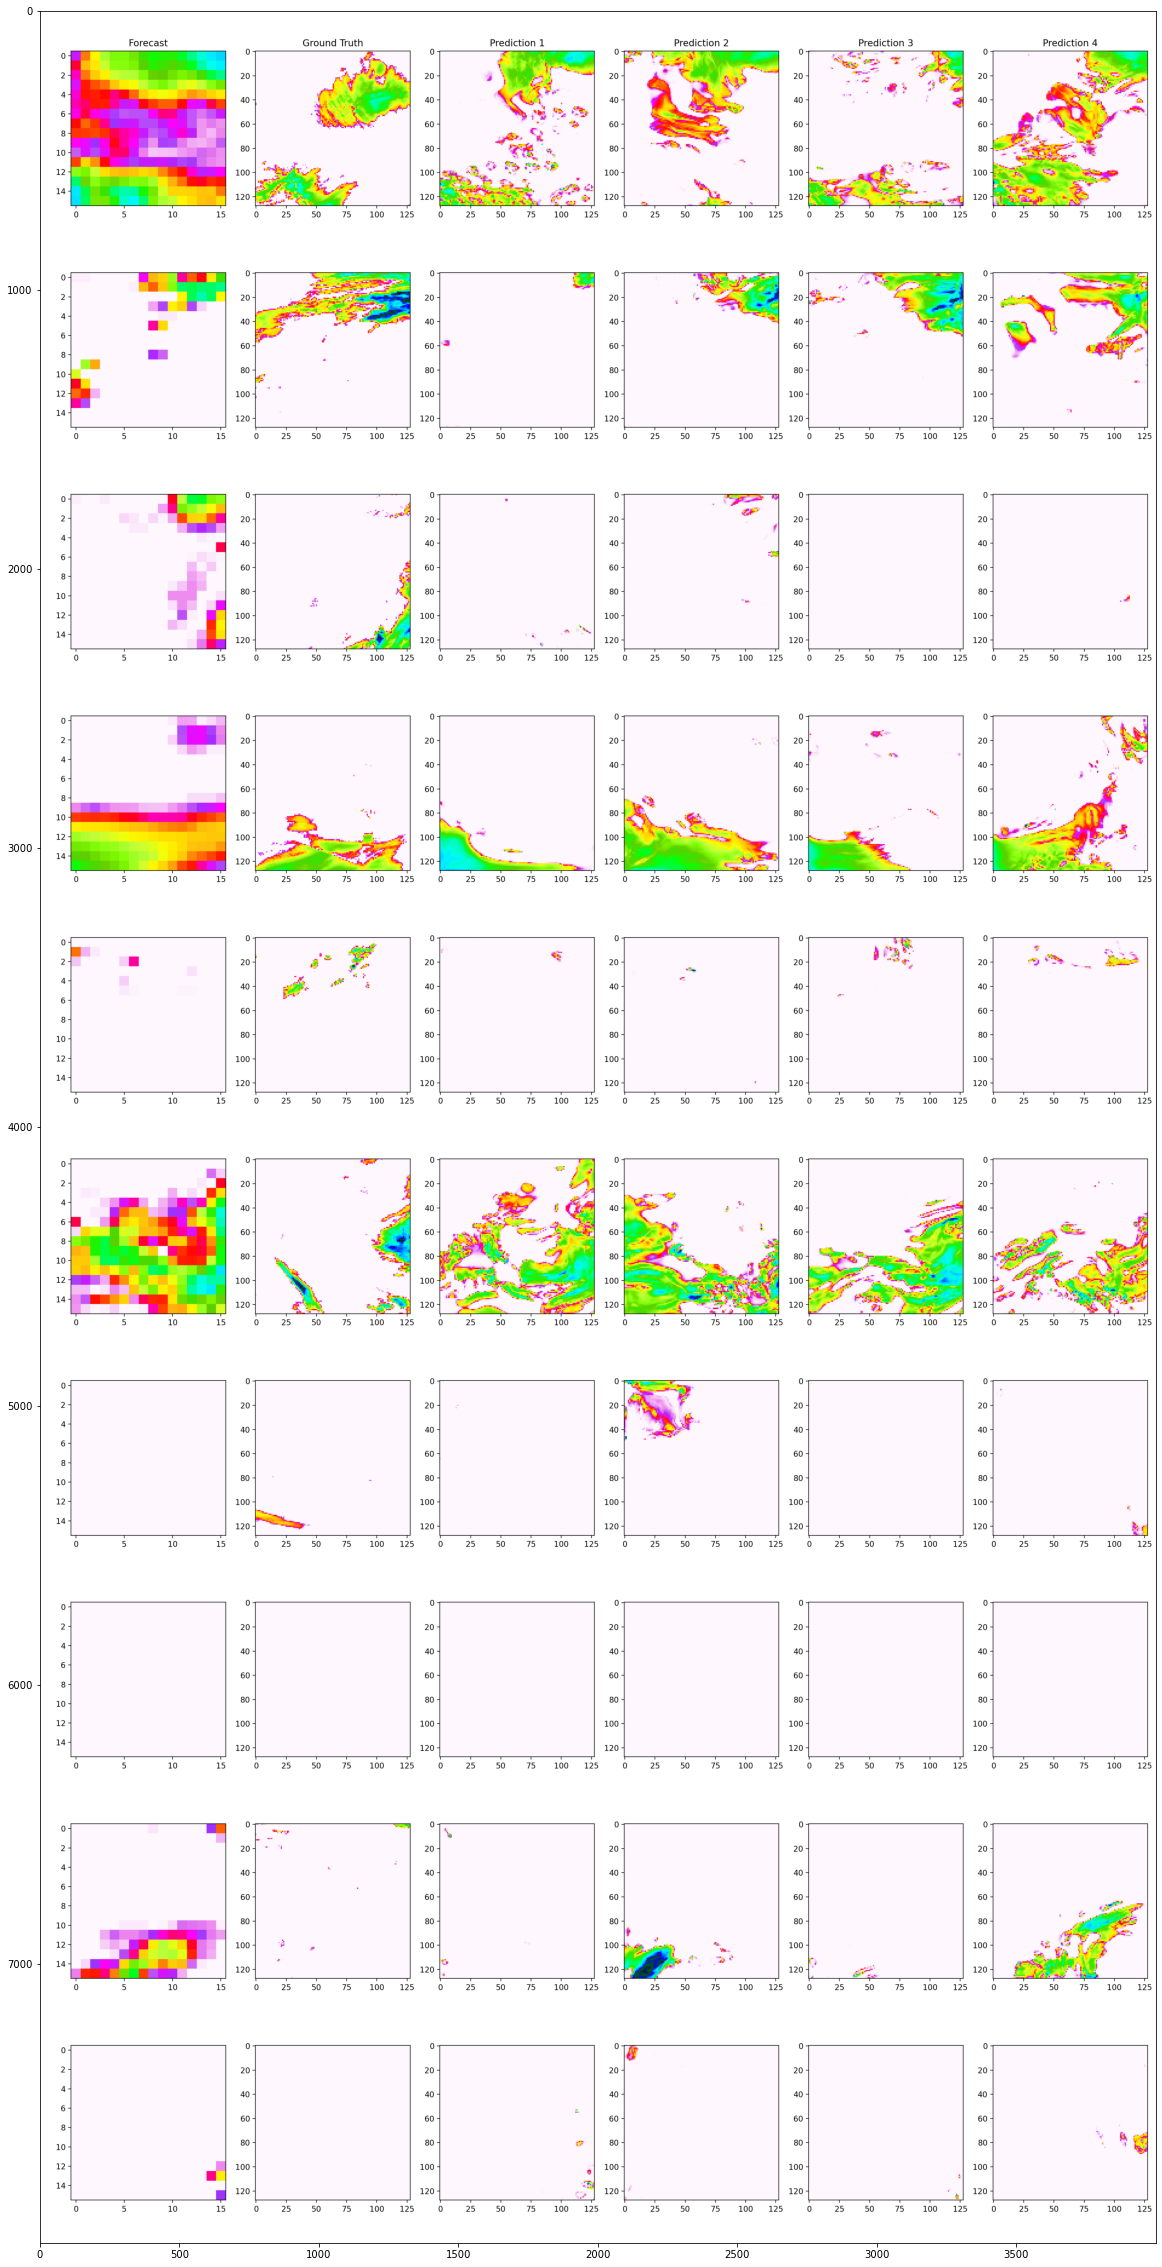

In [16]:
plt.figure(figsize=(20, 45))
plt.imshow(leingan_single_forecast_preds)

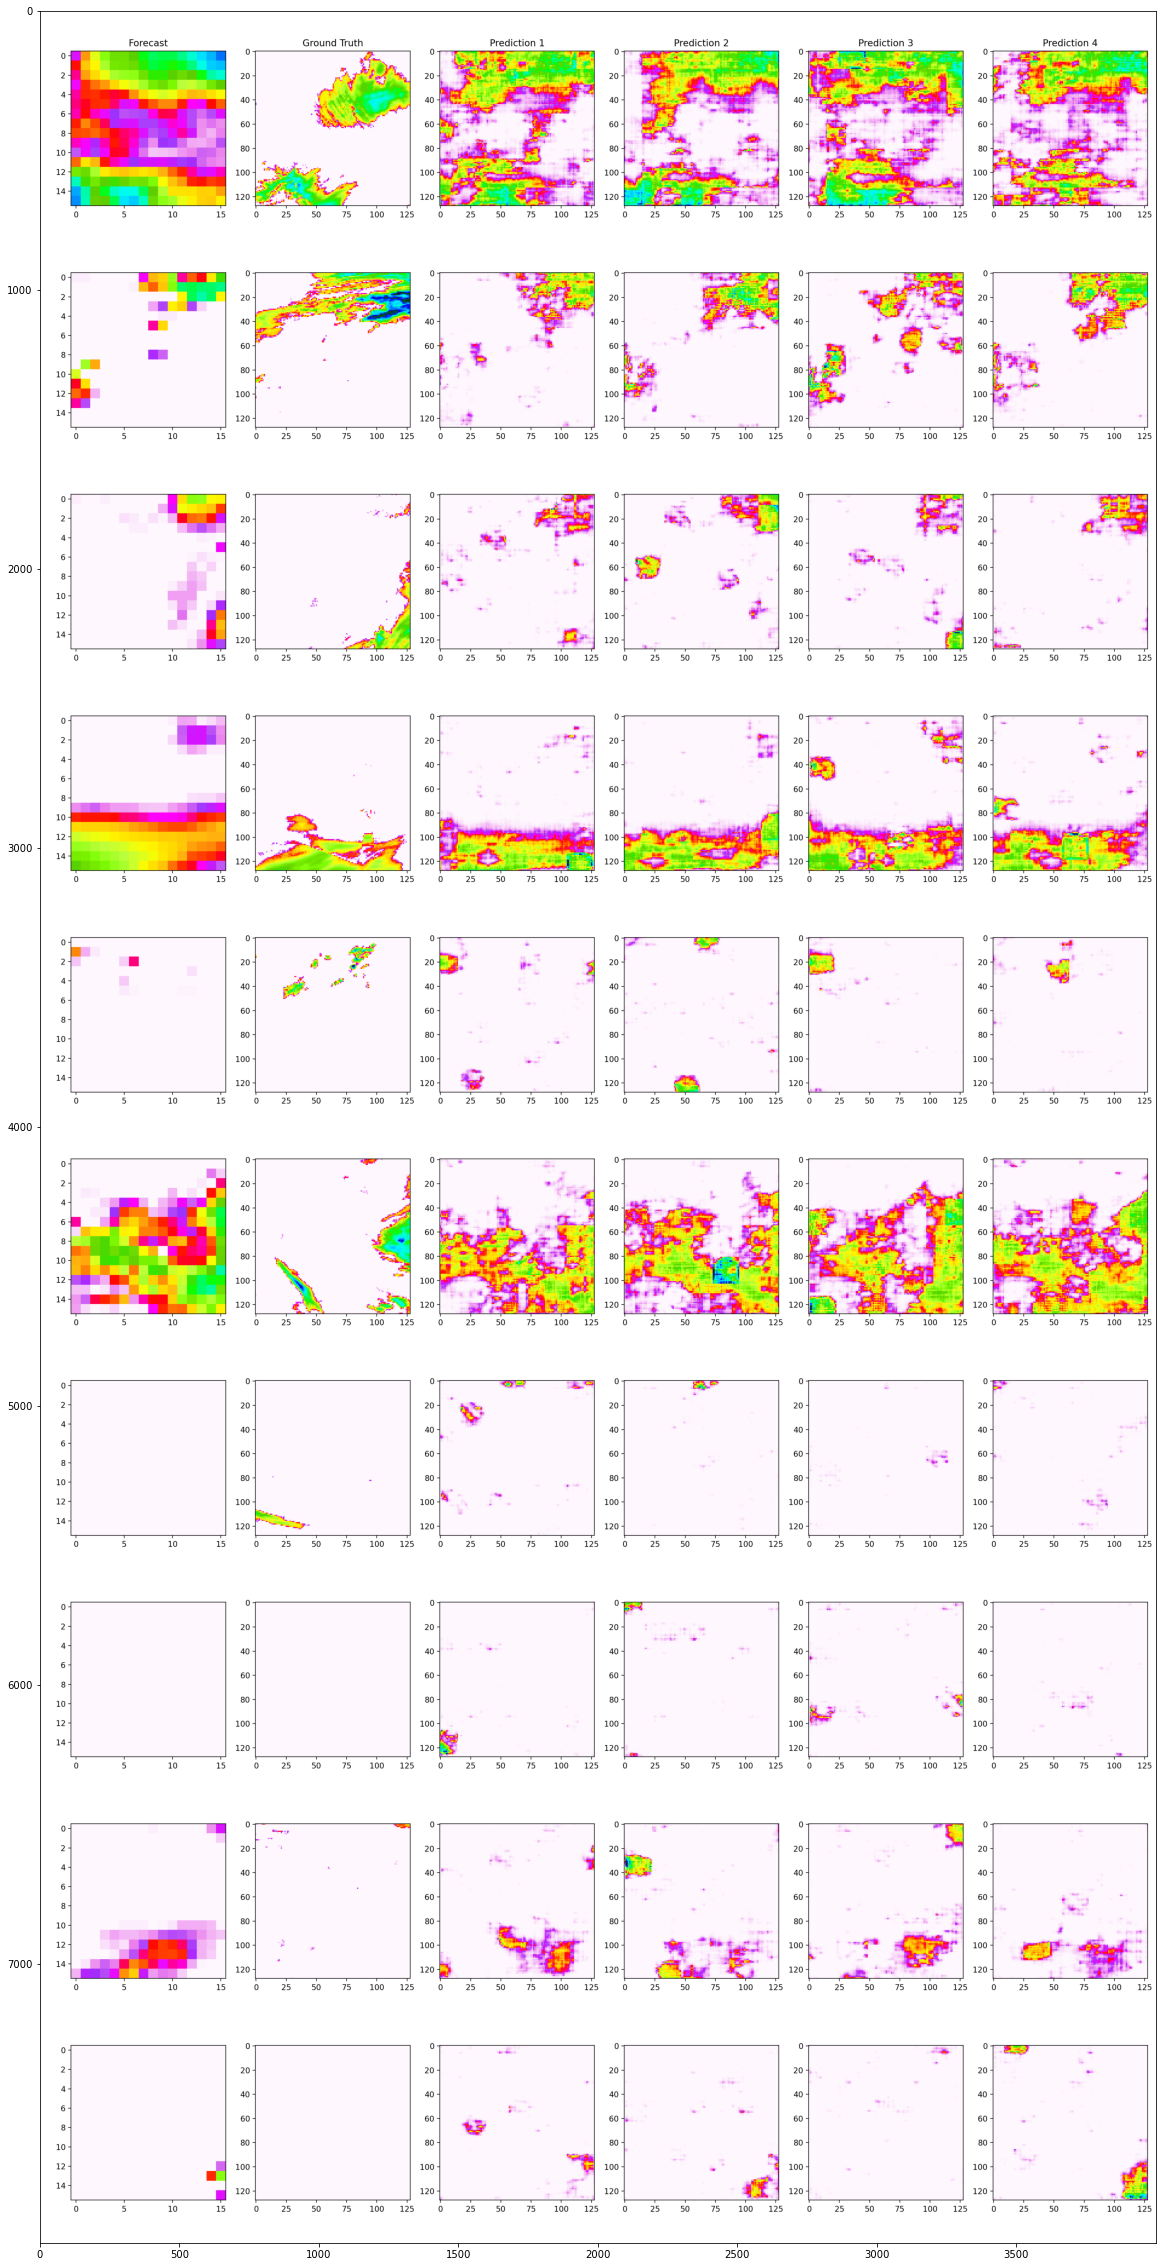

In [17]:
plt.figure(figsize=(20, 45))
plt.imshow(wgan_gp_preds)

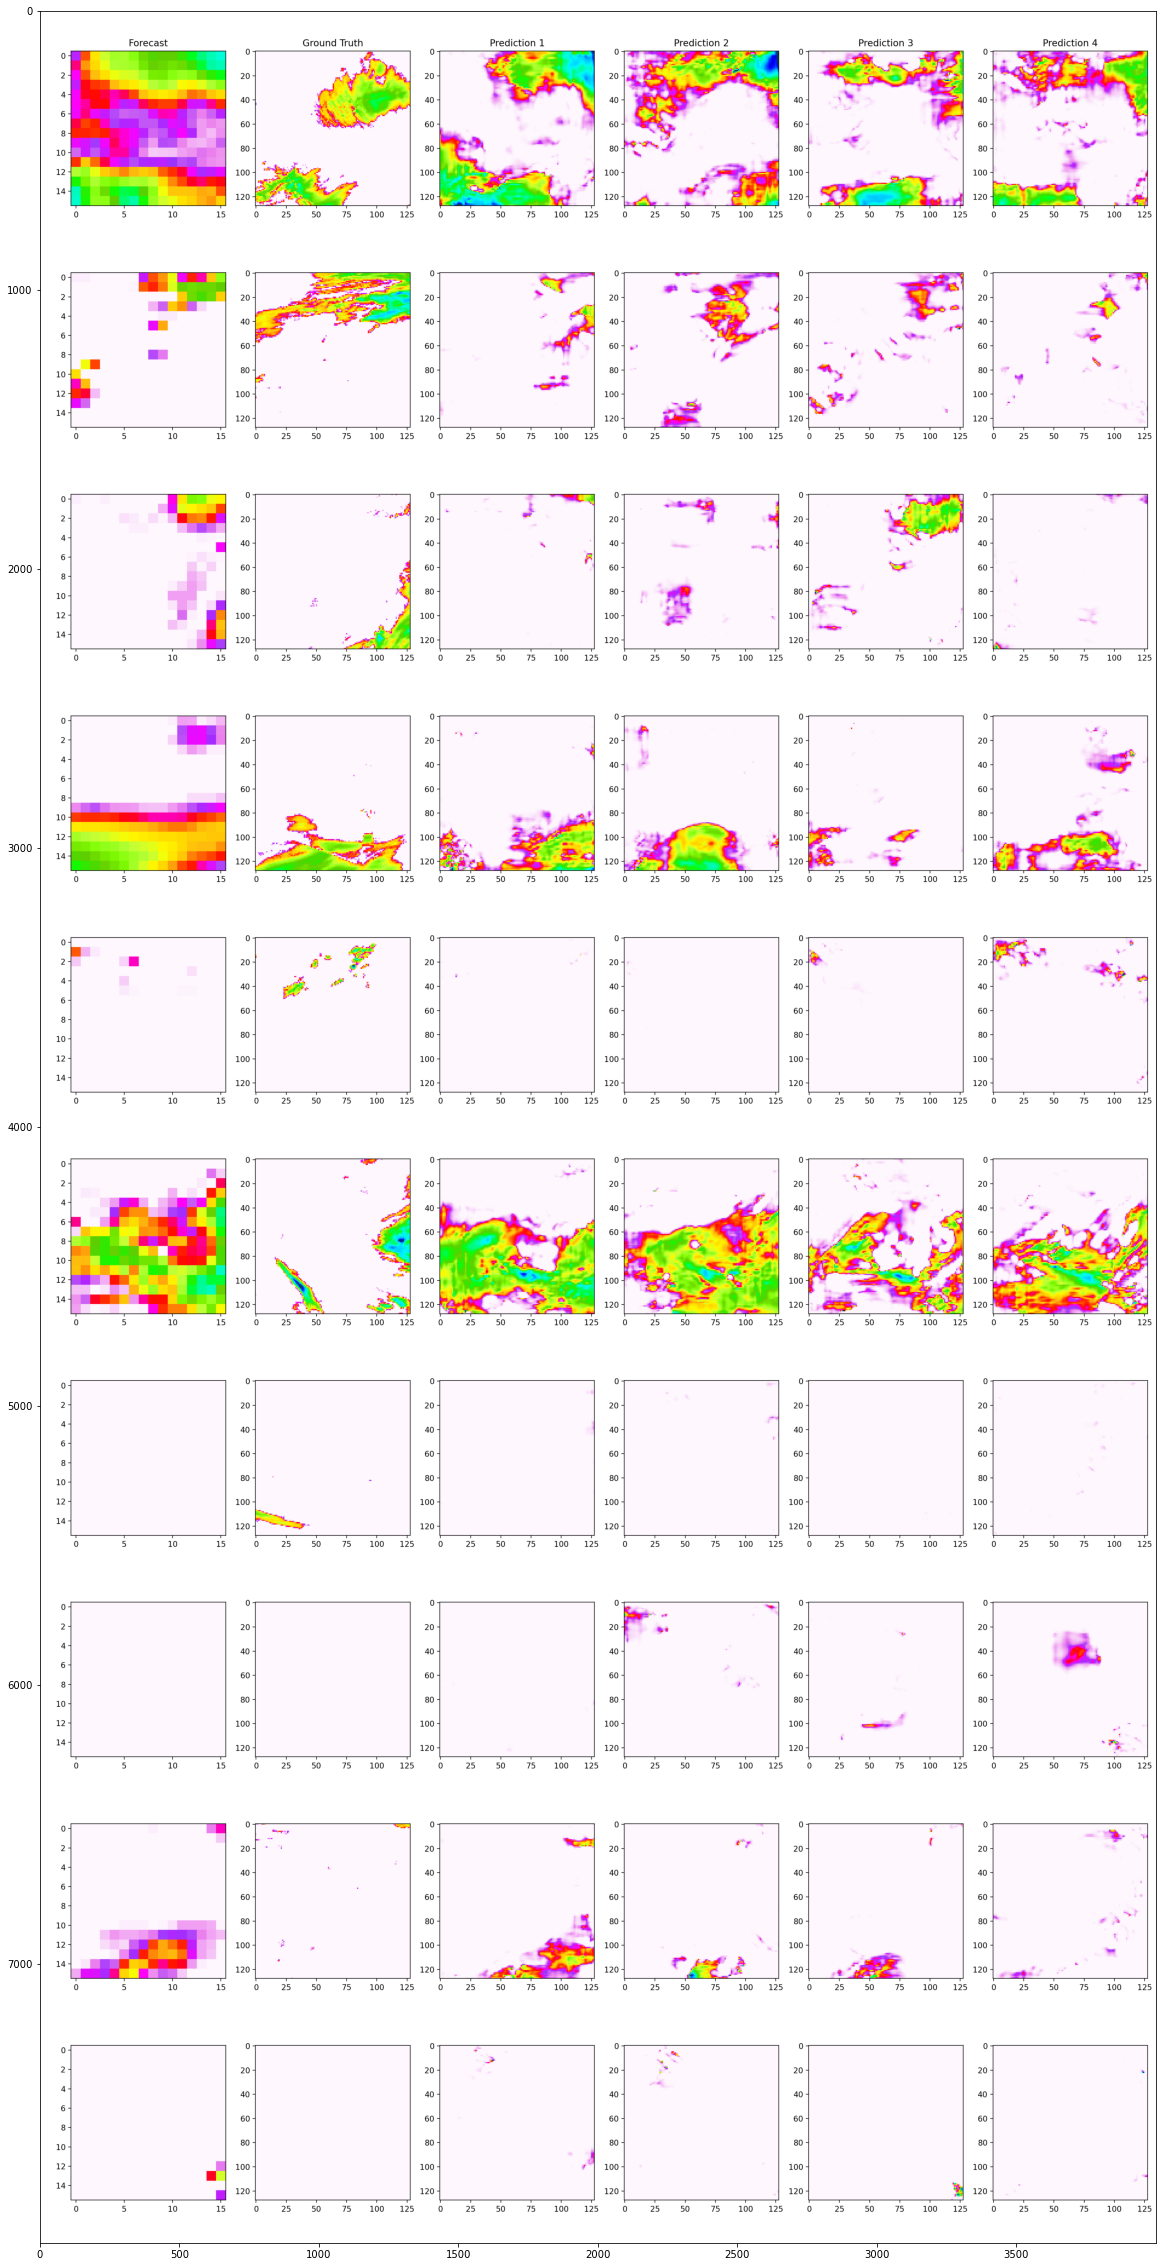

In [18]:
plt.figure(figsize=(20, 45))
plt.imshow(wgan_gp_smoothed_preds)

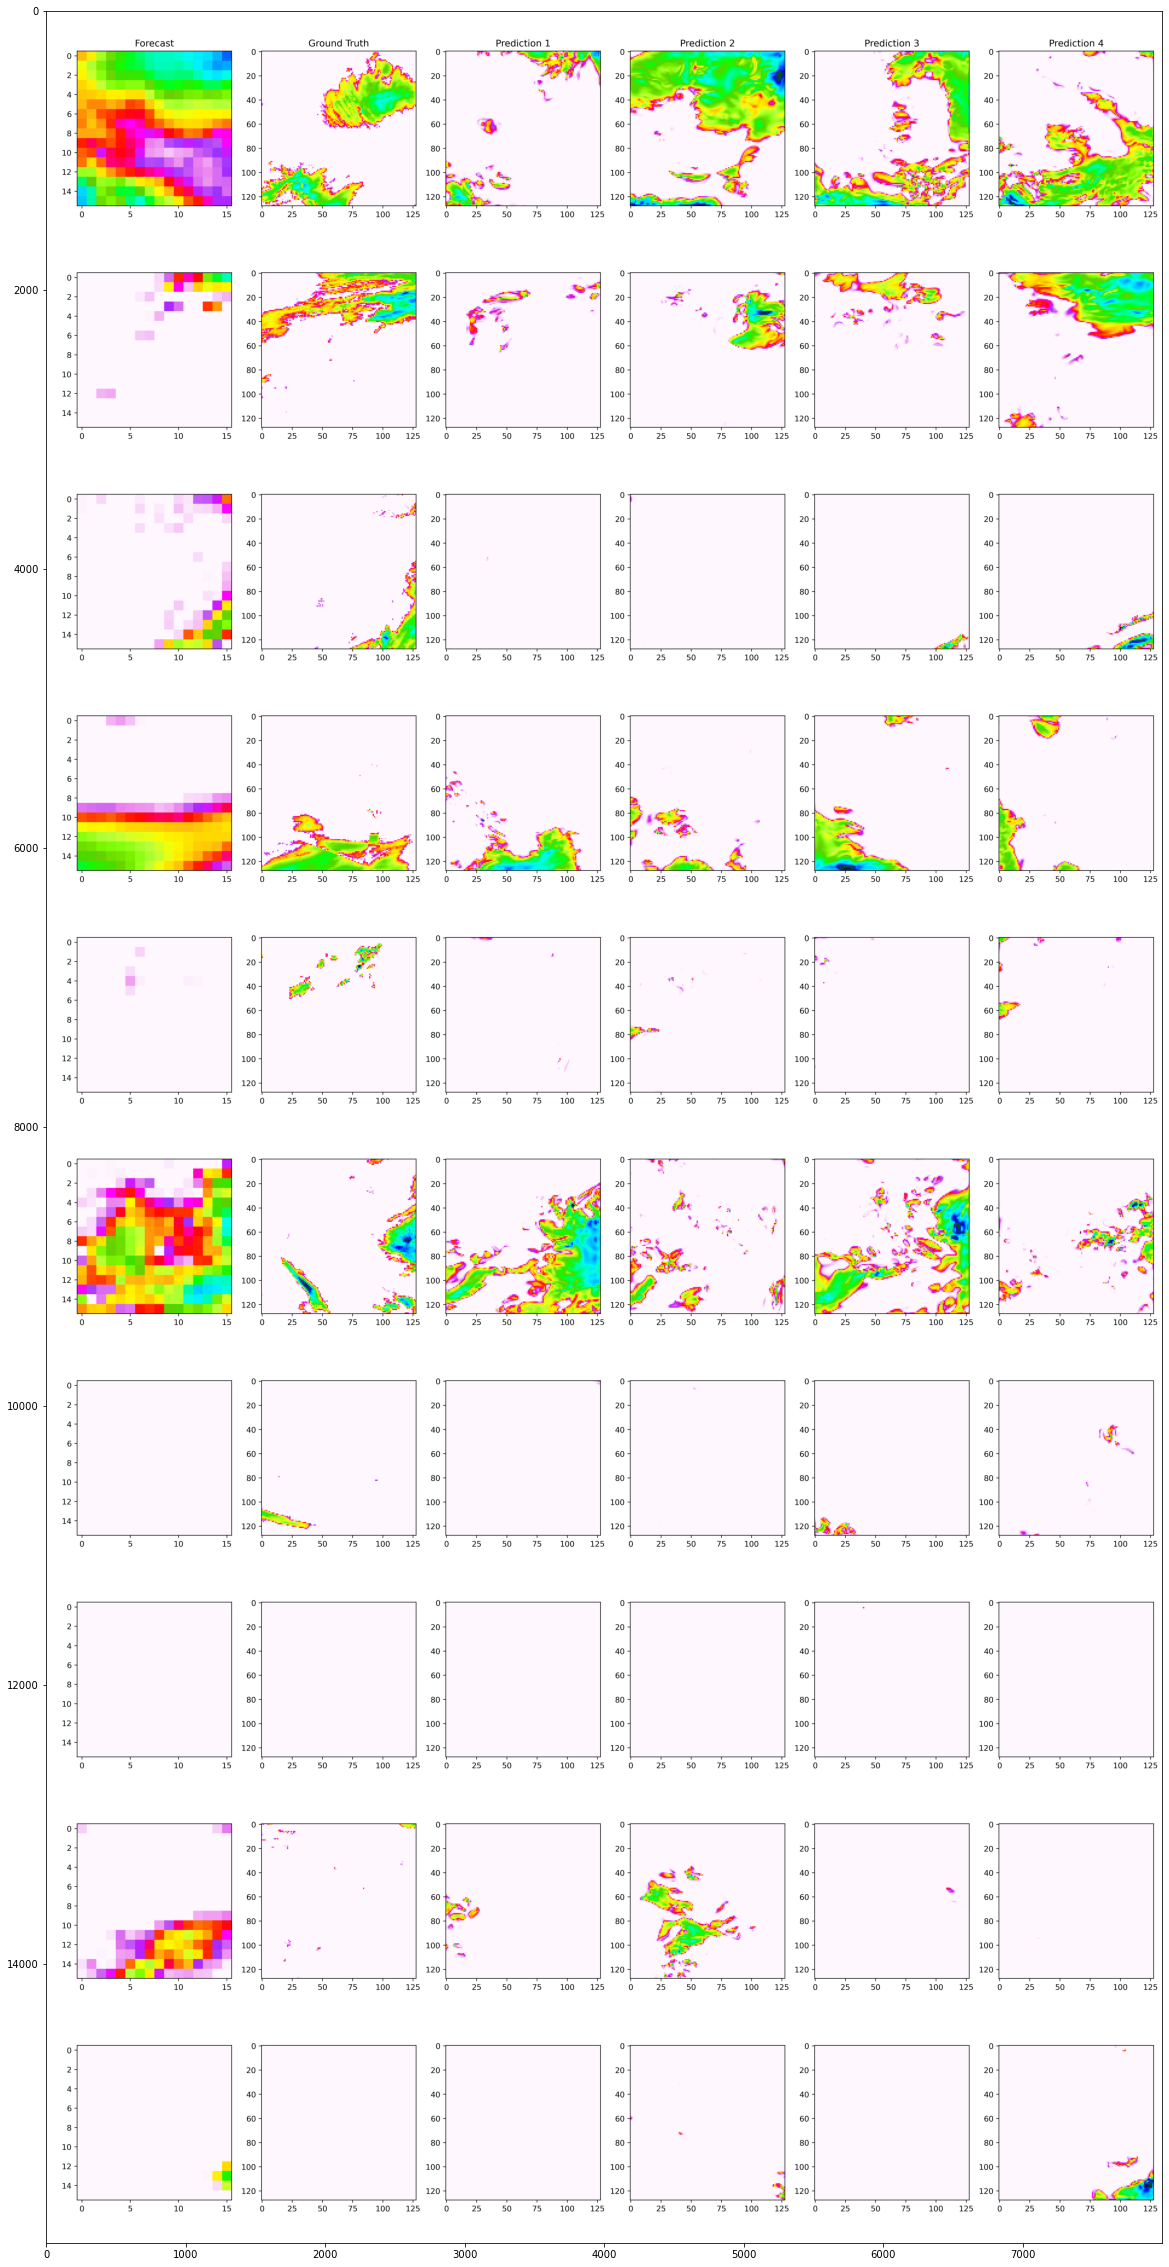

In [19]:
plt.figure(figsize=(20, 45))
plt.imshow(leingan_ens10_temp_random_preds)

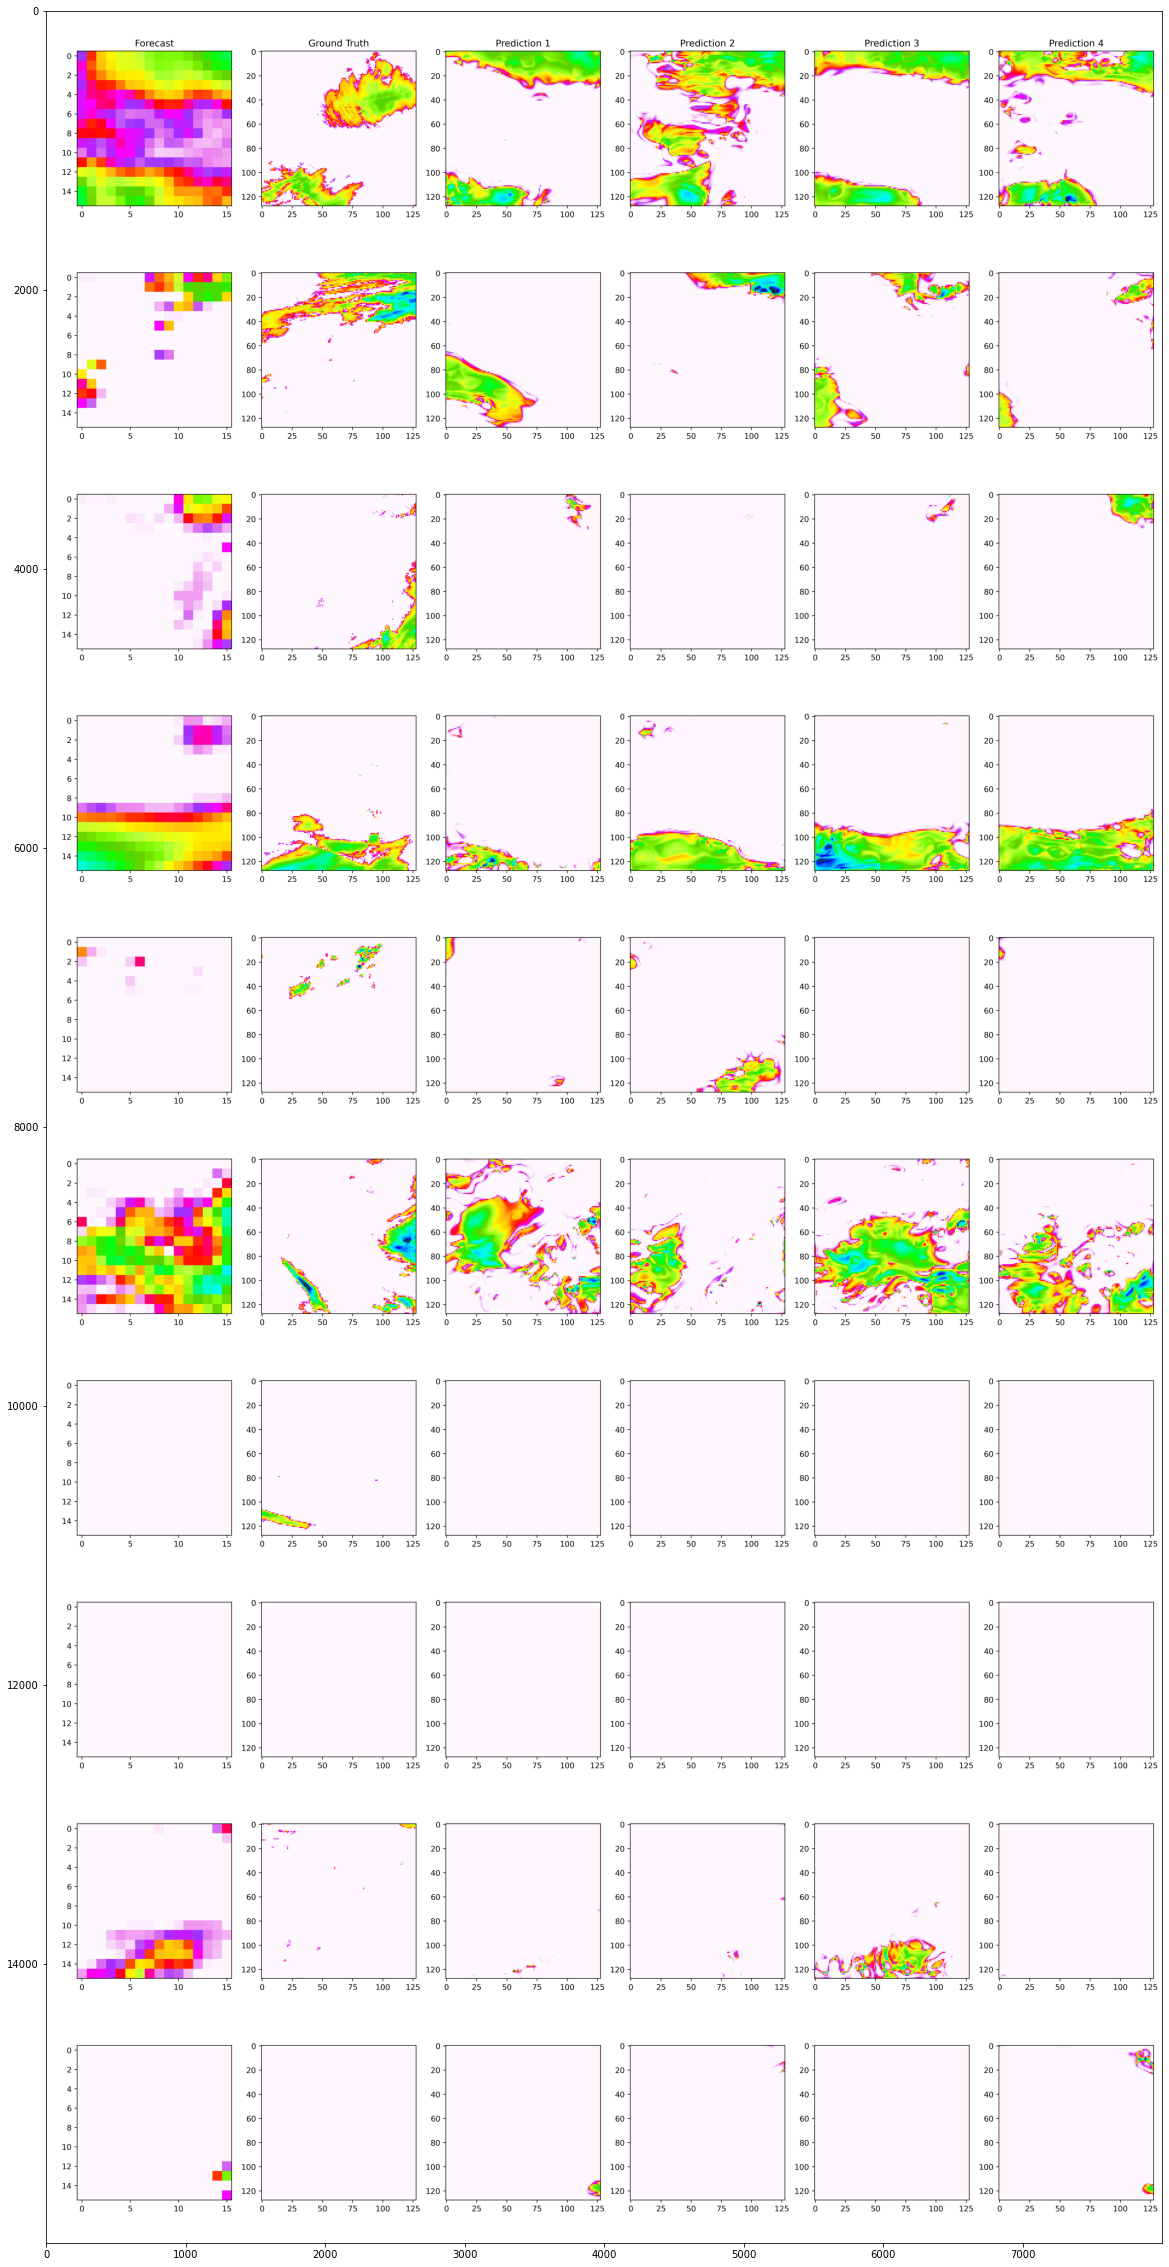

In [20]:
plt.figure(figsize=(20, 45))
plt.imshow(leingan_single_forecast_with_consts_preds)

In [21]:
!jupyter nbconvert view_eval.ipynb --to html

[NbConvertApp] Converting notebook view_eval.ipynb to html
[NbConvertApp] Writing 5604588 bytes to view_eval.html
